# Purcell's Swimmer


In this notebook we will make a self-propelling Purcell Swimmer and dip it in a highly viscous fluid.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style("whitegrid")
plt.rcParams["animation.html"] = "jshtml"
from celluloid import Camera
import stokeslets as slts
import purcell as pur

In [2]:
figfile = "figs/"

## 1. Geometry

We need to define the position of the rods and the motors. Let's construct the swimmer with 3 rigid rods and place the end points of the rod in the $S_1$ configuration. The rod is parametrised by $\eta$ and $\phi$.

In [3]:
et = 0.5
ph = np.pi/3
size = 0.5

In [4]:
s = np.zeros([4,3]);
s[1,0:2] = np.array([-size/2,0]) #motor 1
s[2,0:2] = np.array([size/2,0]) #motor 2
s[0,0:2] = np.array([-size*et*np.cos(ph)-size/2,size*et*np.sin(ph)]) #arm 1
s[3,0:2] = np.array([size*et*np.cos(ph)+size/2,size*et*np.sin(ph)]) #arm 2
r = np.array([1,2]) #motor specifications

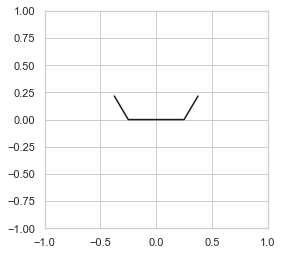

In [5]:
plt.figure(figsize=(4,4))
plt.plot(s.T[0],s.T[1],'k-')
plt.xlim(-1,1); plt.ylim(-1,1);

## 2. Dynamics

Define the time vector.

In [6]:
dt = 0.01
T = 16
tim = np.arange(0,T,dt)

Let's define $\tau_1 = [0,0,q_1(t)]$ and $\tau_2 = [0,0,q_2(t)]$.

In [7]:
tau = np.array([np.zeros(np.shape(tim)+(3,))]*np.size(r))

In Purcell's paper, the swimmer moves one arm at a given time. This can be achieved by a constant torque difference between the two motors. To describe this motion, we need a parameter $P = |q_2(0)|$ which is the maximum torque exerted by one of the motors. For simplicity, we assume that the other motor exerts no torque when the first is switched on.

In [8]:
P = 1.463 #maximum power
tau = pur.stroke_input(P,tim,r,strokes=2) #the second motor exerts no torque when the first is moving

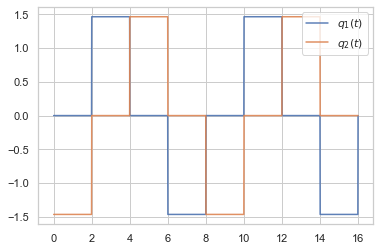

In [9]:
plt.plot(tim,tau[0,:,-1],'-',alpha=0.9);
plt.plot(tim,tau[1,:,-1],'-',alpha=0.9);
plt.legend(["$q_1 (t)$","$q_2 (t)$"],loc="upper right");

## 3. It Swims!

In [10]:
R = slts.mesher()

In [11]:
_,pswimmer = slts.evolve(tau,tim,R,r,s,k=100,e=0.3,c=0.6)

In [12]:
fig = plt.figure(figsize = (4.5,4.5))
plt.xlim(-1,1); plt.ylim(-1,1)
camera = Camera(fig)
for i in range(0,np.shape(pswimmer)[0],10):
    plt.plot(pswimmer[i].T[0],pswimmer[i].T[1],'k-', linewidth=2, alpha=0.5, label='_nolegend_')
    plt.plot(np.mean(pswimmer[i].T[0]),np.mean(pswimmer[i].T[1]),'ro', linewidth=2, alpha=0.5)
    camera.snap()
plt.legend(["CoM"])
plt.close()

In [13]:
animation = camera.animate()
animation.save(figfile+"purcell_swimmer.gif",writer = 'imagemagick',fps = 20,dpi=300)
animation

## 4. Purcell Strokes
We can try finding the torque difference required for a Purcell stroke by trial and error, but it would be easier to sample different $P$ values and see which corresponds to a Purcell stroke.

Let's determine the difference between the arm angle after one stroke and the starting angle $\phi$ for the arm that moves second. For a Purcell stroke, this value, which we call $\Delta\phi_0$, should be equal to $0$.

In [14]:
pur.delphinought(tau,pswimmer,ph)

0.0012367714667014251

Now, we can try sampling over the parameter space to see which values of $P$ minimize $\Delta\phi_0$.

In [15]:
et = 0.5 #eta value
ph = np.pi/3 #phi value

res = 0.1
P_vec = np.arange(0.6,1.6+res,res) #range of P values

delphi0 = np.zeros(np.shape(P_vec))

for i,P in enumerate(P_vec):
    s,r,tim = pur.init(et,ph,T=8)
    tau = pur.stroke_input(P,tim,r,strokes=1)
    R = slts.mesher()
    try:
        _,pswimmer = slts.evolve(tau,tim,R,r,s,k=100,e=0.3,c=0.6)
        delphi0[i] = pur.delphinought(tau,pswimmer,ph)
    except ValueError: #sometimes the swimmer can swim out of frame
        delphi0[i] = None
    print("Progress:",np.round((i+1)/np.size(P_vec)*100,2),"%")

Progress: 9.09 %
Progress: 18.18 %
Progress: 27.27 %
Progress: 36.36 %
Progress: 45.45 %
Progress: 54.55 %
Progress: 63.64 %
Progress: 72.73 %
Progress: 81.82 %
Progress: 90.91 %
Progress: 100.0 %


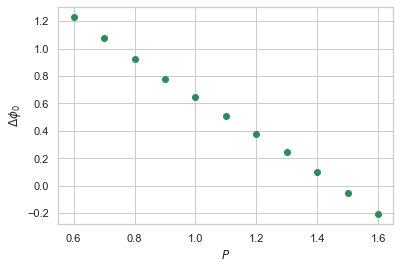

In [16]:
plt.plot(P_vec,delphi0,'o',color='seagreen');
plt.ylabel(r"$\Delta\phi_0$")
plt.xlabel(r"$P$");

The linearity simplifies our job quite a bit. We can now interpolate to obtain a function that returns a value for $\Delta\phi_0=0$.

In [17]:
func = sp.interpolate.interp1d(delphi0, P_vec)
P0 = func([0])[0]

In [18]:
print("P:",round(P0,3))

P: 1.463
